<a href="https://colab.research.google.com/github/ratulKabir/PNCA/blob/main/gnca%2Bpc_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab: https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/growing_ca.ipynb#scrollTo=i5wi_r4gyzFr

In [ ]:
import numpy as np
import PIL.Image, PIL.ImageDraw
import io
import tensorflow as tf
import requests
import matplotlib.pylab as pl
import json

from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import Image, HTML, clear_output

def np2pil(a):
    '''
    Input: a = numpy array
    Output: Image memory of 'a'
    '''
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
    return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
    '''
    Input: f = name with image extension from/of what?
           a = Object to be converted to image memory
           fmt = format?
    Output: saves the array into image file with give name 'f'
    '''
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
    '''
    Input: a = Object to be converted to image memory
    Output: bytes containing the entire contents of the buffer.
    '''
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
    data = imencode(a, fmt)
    clear_output()
    display(Image(data=data))
    
def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]  # height and width (2nd and 3rd dimention) of the matrix.
    pad = (w - len(a)) % w
    pad = (w-len(a))%w
    a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
    h = len(a)//w
    a = a.reshape([h, w]+list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
    return a

def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img

class VideoWriter:
    def __init__(self, filename, fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)
        
    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)
    
    def close(self):
        if self.writer:
            self.writer.close()
            
    def __enter__(self):
        return self
    def __exit__(self, *kw):
        self.close()

#@title CA Model and Utilities

def load_image(url, max_size):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji(emoji, max_size):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
    return load_image(url, max_size)

def to_rgba(x):
    return x[..., :4]

def to_alpha(x):
    return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return 1.0-a+rgb

def get_living_mask(x):
    alpha = x[:, :, :, 3:4] # alpha is the 4th channel. It indicates is cell is livie or dead
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1 

def make_seed(size, n=1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size//2, size//2, 3:] = 1.0
    return x

#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn, channel_n):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, channel_n]),
#       y=tf.TensorSpec([None, None, None, channel_n*3]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log, name='Loss'):
  pl.figure(figsize=(10, 4))
  pl.title(f'{name} history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.4)
  pl.show()


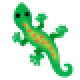

In [ ]:
import numpy as np
import moviepy.editor as mvp
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tqdm
import logging
import glob

# from utils import *
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense

# tf.config.experimental_run_functions_eagerly(True)  # allows tf.function() to create tf.Variable() inside or something

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
os.environ['HTTP_PROXY']='http://proxy:3128/'
os.environ['HTTPS_PROXY']='http://proxy:3128/'
logging.getLogger('tensorflow').disabled = True

%config Completer.use_jedi = False  
        
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch
# DAMAGE_N = False

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

#     self.conv = Conv2D(12, 3, padding='SAME')
    self.dense = Dense(4) # decoder
    self.latent_z = tf.Variable(tf.random.uniform([1, 72, 72, 12]), dtype=tf.float32, name="latent_z")

#     self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

#   @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

#   @tf.function
  def update_latent(self, loss, tape, precision=0.01):
    grads = tape.gradient(loss, self.latent_z)
#     print(self.latent_z.shape)
#     print(grads.shape, loss.shape)
    self.latent_z = self.latent_z - (grads*precision)
    
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)
    
    # ________ Predictive Coding____________
    
    #updating latent space
    with tf.GradientTape() as tape:
      tape.watch(self.latent_z)
      latent_pred = self.perceive(x) # sobel+identity filters' output
      latent_loss = tf.square(latent_pred - self.latent_z)
    
#   update latent_Z
    self.update_latent(latent_loss, tape)
    
    # this is the decoder step
    dx = self.dense(self.latent_z)
    dx *= step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


# CAModel().dmodel.summary()

target_img = load_emoji(TARGET_EMOJI, TARGET_SIZE)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def add_noise(img, mean=0.0, std=0.1):
    noisy_pad_target = img + np.random.normal(mean, std, img.shape)
    noisy_pad_target = np.clip(noisy_pad_target, 0, 1)
    noisy_pad_target *= np.tile(img[..., -1, None], noisy_pad_target.shape[-1])
    
    return noisy_pad_target.astype(np.float32)

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

def loss_per_pix(x):
  return tf.square(to_rgba(x)-pad_target)

# def loss_gaus(x):
#   return tf.reduce_mean(tf.square(to_rgba(x)-add_noise(pad_target)), [-2, -3, -1])

ca = CAModel()

# loss_log = []
loss_log = []
# state_loss_log = []

# y_from_label = np.load('y_from_label_39.npy')

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

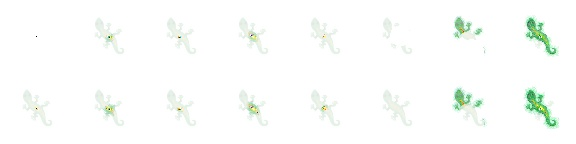

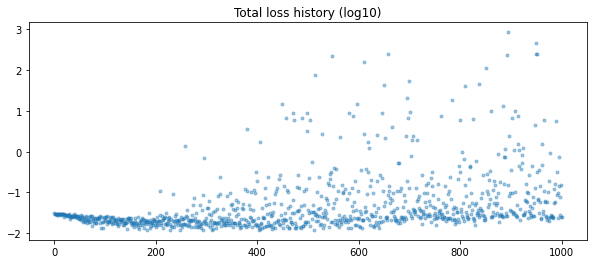

 step: 1002, log10(loss): 0.161

In [ ]:
#@title Training Loop {vertical-output: true}
# ca = CAModel()

# @tf.function
def train_step(x):
#     iter_n = tf.random.uniform([], 1, 1, tf.int32)
    with tf.GradientTape() as g:#, tf.GradientTape() as g_lat:
        g.watch(ca.latent_z)
        for i in tf.range(2):
            x = ca(x)
        # sensory loss
        loss = loss_per_pix(x)
        
#     ca.update_latent(loss, g_lat, 0.0001)
    x += (loss*0.1)
    grads = g.gradient(loss, ca.weights)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    trainer.apply_gradients(zip(grads, ca.weights))

    return x, loss


for i in range(500+1):
    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = batch.x
        loss_rank = loss_f(x0).numpy().argsort()[::-1]
        x0 = x0[loss_rank]
        x0[:1] = seed
    if DAMAGE_N:
        damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
        x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

#     x0 = x0[..., :4]
    x, loss = train_step(x0)
    loss = tf.reduce_mean(loss)
    #   break

    if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.numpy())

    if step_i%10 == 0:
        generate_pool_figures(pool, step_i)
    if step_i%100 == 0:
        clear_output()
        visualize_batch(x0, x, step_i)
        plot_loss(loss_log, 'Total loss')
    #     export_model(ca, 'train_log/%04d'%step_i, CHANNEL_N)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

Text(0.5, 1.0, 'Sensory Error')

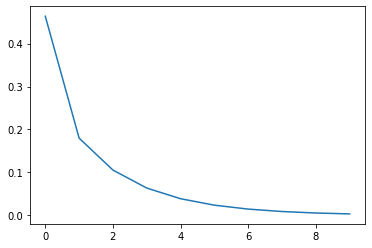

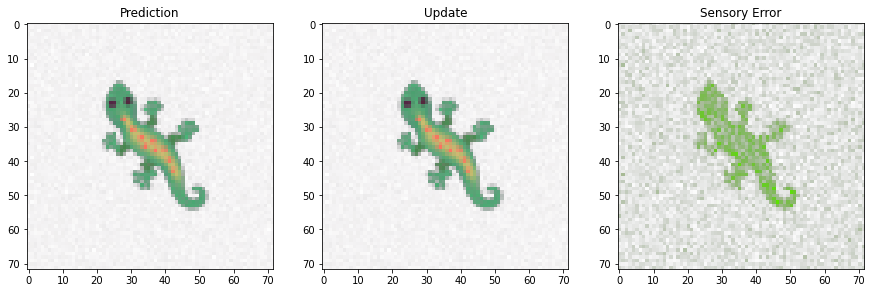

In [ ]:
def scale_bet_0_1(inp):
    inp = np.array(inp)
    inp -= inp.min()
    inp /= (inp.max() - inp.min())
    
    return inp

batch = pool.sample(BATCH_SIZE)
x0 = batch.x
loss_rank = loss_f(x0).numpy().argsort()[::-1]
x0 = x0[loss_rank]
x0[:1] = seed
x_inp = x0[0:1, :, :, :4]
# input == x0 # target == pad_target

optimizer = tf.keras.optimizers.Adam()
latent_z = tf.Variable(tf.random.uniform([1, 72, 72, 12]), dtype=tf.float32, name="latent_z")
dec_z2x = Dense(4)
conv_td = Conv2D(12, 3, padding='SAME')
l_prev = latent_z
# dec_z2x = tf.Variable(tf.random.uniform([12, 4]), dtype=tf.float32, name="dec_z2x")

n_steps = 10
precision = 1
loss = []

x_pred_bef_update = dec_z2x(latent_z)
# for st in range (n_steps):
#     with tf.GradientTape() as tape:
#         latent_pred = conv_td(x_inp)

#         latent_err = tf.square(latent_z - latent_pred)
#     grads = tape.gradient(latent_err, latent_z)
#     latent_z.assign_sub(grads * 0.2)
    
for st in range(n_steps):
    with tf.GradientTape() as tape:                
        x_pred = dec_z2x(latent_z)
        x_pred_bef_update = x_pred

        sens_pred_err = tf.square(pad_target - x_pred) * precision

    grads = tape.gradient(sens_pred_err, latent_z)
    latent_z.assign_sub(grads * 0.2)
#     x_pred -= (grads*1)

#     optimizer.apply_gradients(zip(grads, dec_z2x.weights))

    print(tf.reduce_mean(sens_pred_err).numpy(), end='\r')
    loss.append(tf.reduce_mean(sens_pred_err))

# x_pred += (sens_pred_err * 1)



# ca.perceive(x_inp).shape
# tf.reduce_mean(sens_pred_err)
plt.plot(loss)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(x_inp)
# ax[0].set_title('Input')
ax[0].imshow(scale_bet_0_1(np.squeeze(x_pred_bef_update)))
ax[0].set_title('Prediction')
ax[1].imshow(scale_bet_0_1(np.squeeze(x_pred)))
ax[1].set_title('Update')
ax[2].imshow(scale_bet_0_1(np.squeeze(sens_pred_err)))
ax[2].set_title('Sensory Error')